# **Build a Multi-Modal Generation Agent**

In this project, I'll use open-source text-to-image and text-to-video models to generate content. Next, I'll build a **unified multi-modal agent** similar to modern chatbots, where a single agent can support general questions, image generation, and video generation requests.

This project show how to integrate multiple model types under one routing system capable of deciding what modality to use based on the user's intent.



* Use **Text-to-Image** models to generate images from a text.
* Generate short clips with a **Text-to-Video** model
* Build a **Multi-Modal Agent** that answers questions and routes media requests
* Build a simple **Gradio** UI and interact with the multi-modal agent

## Environment Setup

In this project, I'll use open-source Text-to-Image and Text-to-Video models to generate visuals from natural-language prompts. These models are computationally heavy and perform best on GPUs, so its recommended to run this notebook in Google Colab or another GPU-enabled environment. I'll load all models from Hugging Face, which requires authentication.

Before continuing:

Create a Hugging Face account and generate an access token at huggingface.co/settings/tokens

Paste your token in the field below to log in.

In the Colab environment, enable GPU acceleration by selecting Runtime → Change runtime type → GPU.

In [ ]:
from huggingface_hub import login

login(token="Colab Token")

Let's import the required libraries and confirm that PyTorch can detect the available GPU.

In [ ]:
import torch, diffusers, transformers, os, random, gc
print('torch', torch.__version__, '| CUDA:', torch.cuda.is_available())

torch 2.9.0+cu126 | CUDA: True


In [ ]:
# transformer a library by huggingFace allow you to load pre-trained LLMs
# diffusers is equivalent of transformer by huggingface for image and video under huggingFace

## Text-to-Image (T2I)
T2I models translate natural-language descriptions into images. They are typically based on diffusion models, which gradually refine random noise into a coherent picture guided by the text prompt. In this section, I'll load and test one such model to generate images directly from text inputs.

In [ ]:
from diffusers import DiffusionPipeline
import torch

# Define the Stable Diffusion XL model ID from Hugging Face and load the pre-trained model
# model_id =  "stabilityai/stable-diffusion-xl-base-1.0" # this is a larger model
model_id = "runwayml/stable-diffusion-v1-5" # this is a smaller model

# torch.cuda.empty_cache() # Clear any cached memory before loading a new model

image_pipeline = DiffusionPipeline.from_pretrained(
    model_id,
    dtype=torch.float16, # this is efficient, but can also run with float32 but its going to be large
    variant='fp16'
).to('cuda')

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:

# when the sequence length is small, the overhead is more
# when the sequence length is large, for example 32,000 or beyong, then thats where the real benefit would appear
# you gonna save a lot on memory

image_pipeline.enable_attention_slicing()
image_pipeline.enable_model_cpu_offload()

# Purpose: reduces GPU memory (VRAM) usage during the pipeline's attention computations by splitting attention into smaller slices
# instead of computing the whole attention matrix at once.

# When to use: run large diffusion models (e.g., SDXL) on limited‑memory GPUs to avoid OOM errors.

# Tradeoffs: lowers peak memory but can slightly increase inference time.

# Typical placement: call once after loading the DiffusionPipeline (as in your notebook) before generating images.

## Text-to-Video (T2V)
T2V models extend the idea of diffusion from still images to moving sequences. Instead of generating one frame, they create a series of coherent frames that depict motion consistent with the text prompt. These models are computationally heavier and often generate short clips (typically 2-10 seconds).

In this section, I'll load an open-source video diffusion model and prepare it for generation.

### Load a T2V model

We'll use the model `damo-vilab/text-to-video-ms-1.7b`, which can produce short video clips from text prompts. This model benefits from a specialized scheduler (DPMSolverMultistepScheduler) that improves stability and speed during sampling.

In [ ]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

video_model_id = 'damo-vilab/text-to-video-ms-1.7b'

# Load the model with FP16 precision for efficiency
video_pipeline = DiffusionPipeline.from_pretrained(
    video_model_id,
    torch_dtype=torch.float16,
    variant="fp16"
)
video_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    video_pipeline.scheduler.config,
    algorithm_type="sde-dpmsolver++"
)
video_pipeline.enable_model_cpu_offload()
# video_pipeline.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The TextToVideoSDPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 


## Multimodal Generation Agent
Now that I have text-to-image, text-to-video, and basic LLM question answering, I will build a single agent that routes user requests to the right capability. The agent will read a prompt, infer intent (chat vs image vs video), and return the appropriate output.

### Load an LLM for generic queries
Use a small LLM as the default chat brain. I will start with `gemma-3-1b-it` and keep the loading logic simple. I can swap to another compact chat model later.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch, textwrap, json, re

# Load google/gemma-3-1b-it using Hugging Face

model_id = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
gemma_llm = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


### Build a routing mechanism to route requests

In [ ]:
def generate_media(prompt: str, mode: str):
    print("mode: ", mode)
    # Produce either an image or a short video clip from a text prompt.
    if mode == 'image':
        print("Image Pipeline triggered...")
        return image_pipeline(prompt).images[0]
    elif mode == 'video':
        print("Video Pipeline triggered...")
        return video_pipeline(prompt, num_frames=16, num_inference_steps=20).frames[0]
    else:
        return 'Invalid mode'

def llm_generate(prompt, max_new_tokens=64, temperature=0.7):
    # Return a response to the prompt with the loaded gemma
    outputs = gemma_llm(prompt, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    return outputs[0][0]['generated_text'][-1]["content"]

In [ ]:
def classify_prompt(prompt: str):
    """Classify the user prompt into QA, image, or video."""

    # Step 1: Define a system prompt explaining how to classify requests (qa, image, video)
    # Step 2: Format the user message and system message as input to the LLM
    # Step 3: Generate a response with llm_generate() and parse it using regex
    # Step 4: Extract fields "type" and "expanded_prompt" from the LLM response
    # Step 5: Return a dict with classification results or default to {"type": "qa"} on failure

    system = textwrap.dedent("""You are a routing assistant for a multimodal generation system.
        Decide whether the USER request is:
          • a factual or conversational question  →  type = "qa"
          • an IMAGE generation request          →  type = "image"
          • a VIDEO generation request           →  type = "video"
        If it is for image or video, produce an improved, vivid, detailed `expanded_prompt`.
        Respond ONLY in this format: {"type": "...", "expanded_prompt": "..."}
    """)
    messages = [
      [
          {
              "role": "system",
              "content": [{"type": "text", "text": system},]
          },
          {
              "role": "user",
              "content": [{"type": "text", "text": prompt},]
          },
      ],
    ]
    response = llm_generate(messages, temperature=0.2)
    match = re.search(r'"type"\s*:\s*"([^"]+)"\s*,\s*"expanded_prompt"\s*:\s*"([^"]+)', response)
    if match:
        try:
            result = {
              "type": match.group(1),
              "expanded_prompt": match.group(2)
            }
            return result
        except Exception:
            pass
    # fallback
    return {"type": "qa"}


### Build the multimodal agent
This agent takes a single user prompt, sends it to the `classify_prompt` to determine what kind of task it is, and then calls the appropriate module:
- QA: use the chat LLM to generate an answer
- Image: use the text-to-image generator
- Video: use the text-to-video generator

Start with a simple version first. It can be improved later by adding better prompts, guardrails, and citation handling.

In [ ]:
def multimodal_agent(user_prompt: str):
    # Step 1: Classify the request
    # Step 2: Route the prompt and generate output
    decision = classify_prompt(user_prompt)
    kind = decision.get('type', 'qa')
    print("kind: ", kind)
    if kind == 'qa':
        system = "You are a helpful assistant."
        messages = [
            [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system},]
                },
                {
                    "role": "user",
                    "content": [{"type": "text", "text": user_prompt},]
                },
            ],
        ]
        return llm_generate(messages)
    else:
        return generate_media(decision['expanded_prompt'], mode=kind)

### Test the agent
Now let's test the multimodal agent end to end. Each prompt will automatically be routed to the correct capability: text Q&A, image generation, or video generation, and display the corresponding output.

kind:  qa

PROMPT: What's the capital of Iceland?
The capital of Iceland is **Reykjavik**. 😊
kind:  image
mode:  image
Image Pipeline triggered...


  0%|          | 0/50 [00:00<?, ?it/s]


PROMPT: Generate an image of a neon dragon flying over Tokyo at night


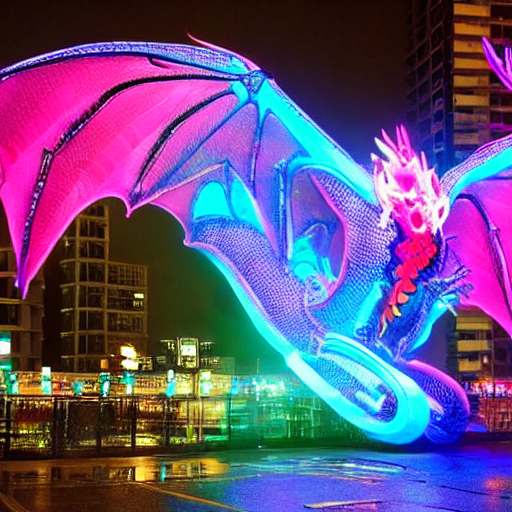

kind:  video
mode:  video
Video Pipeline triggered...


  0%|          | 0/20 [00:00<?, ?it/s]


PROMPT: Create a short video of a paper plane folding itself
video path: /tmp/tmpaq0kejmj.mp4


In [ ]:
from diffusers.utils import export_to_video
from IPython.display import display, Video

# Step 1: Define a few diverse prompts (QA, image, video)
# Step 2: For each prompt, call multimodal_agent and inspect the returned result
for p in [
    "What's the capital of Iceland?",
    "Generate an image of a neon dragon flying over Tokyo at night",
    "Create a short video of a paper plane folding itself"
]:
    result = multimodal_agent(p)
    print('\nPROMPT:', p)
    if isinstance(result, str):
        print(result)
    else:
        if hasattr(result, 'save'):
            display(result)
        else:
            vid = export_to_video(result)
            print(f"video path: {vid}")
            display(Video(vid, embed=True))

## Interactive Web UI

Launch a simple Gradio web interface. We can play with the multimodal agent from the browser.




In [ ]:
import gradio as gr
with gr.Blocks() as demo:
    gr.Markdown('# Multimodal Agent')
    inp = gr.Textbox(placeholder='Ask or create...')
    btn = gr.Button('Submit')
    out_text = gr.Markdown()
    out_img = gr.Image()
    out_vid = gr.Video()

    def handle(prompt):
        res = multimodal_agent(prompt)
        if isinstance(res, str):
            return res, None, None
        elif hasattr(res, 'save'):
            return '', res, None
        else:
            vid = export_to_video(res)
            return '', None, vid

    btn.click(handle, inp, [out_text, out_img, out_vid])

demo.launch()
# demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://da0a4fae71a60a8f77.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


kind:  image
mode:  image
Image Pipeline triggered...


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
import psutil
import os
print(psutil.virtual_memory())

svmem(total=13605851136, available=1726558208, percent=87.3, used=11505872896, free=213925888, active=421294080, inactive=12431089664, buffers=88207360, cached=1797844992, shared=51073024, slab=214294528)


After the UI launches, open the link and generate your own images and videos directly from the browser.

## 🎉 Summary

* We built a **multi-modal agent** capable of understanding various requests, and routing them to the proper model.

Next:
* Try experimenting with other T2I and T2V models.
* Try making the system more efficient. For example, load a separate lightweight llm for routing, and a more capable llm for QA.